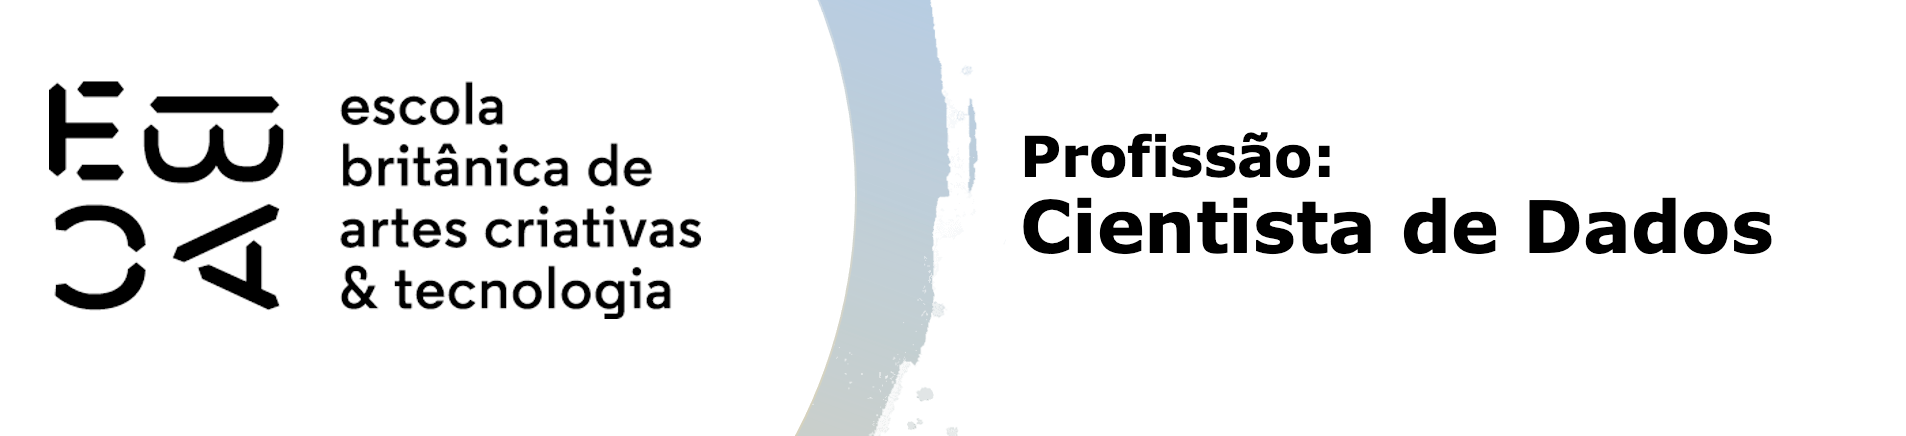

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc
A base possui 125957 nulos presentes na feature 'tempo_emprego', isso equivale a somente 16% dos datapoints por dropna() foi utilizado.A partir do df.info() é possível observar também que o df contém features numéricas e categóricas, um total de 750000 datapoints. Os valores mais frequentes de cada feature são dados por df.mode().iloc[0] a seguir.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [3]:
df.tempo_emprego.isna().sum()/len(df) * 100

16.794266666666665

In [4]:
df.mode().iloc[0]

data_ref                 2015-01-01 00:00:00
index                                 4180.0
sexo                                       F
posse_de_veiculo                           N
posse_de_imovel                            S
qtd_filhos                               0.0
tipo_renda                       Assalariado
educacao                               Médio
estado_civil                          Casado
tipo_residencia                         Casa
idade                                   40.0
tempo_emprego                       4.216438
qt_pessoas_residencia                    2.0
renda                                6193.97
mau                                    False
Name: 0, dtype: object

In [5]:

df.describe()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000,750000.000000,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,2015-08-01 06:24:00,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,2015-04-01 00:00:00,4147.000000,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,2015-08-01 00:00:00,8324.000000,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,2015-12-01 00:00:00,12487.000000,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,2016-03-01 00:00:00,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06
std,NaN,4809.281774,0.739379,11.229868,6.687455,0.903428,7.910601e+04


In [6]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

A variável tempo_emprego apresenta natureza contínua e distribuição assimétrica, com presença de outliers superiores. Nesses casos, o uso da moda concentraria os valores ausentes em um único ponto, distorcendo a densidade da variável. A média também não é apropriada, pois sofre forte influência dos valores extremos. Assim, optou-se pela mediana, que representa melhor a tendência central e preserva a estrutura original da distribuição, garantindo imputação robusta e consistente para análise e modelagem.

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [7]:
def detect_outliers_iqr(df, factor=1.5):
    outlier_summary = {}
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = (df[col] < lower) | (df[col] > upper)
        n_outliers = mask.sum()
        perc = (n_outliers / len(df)) * 100
        outlier_summary[col] = {
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "Lower Bound": lower,
            "Upper Bound": upper,
            "Outliers": n_outliers,
            "% Outliers": round(perc, 3)
        }
    return pd.DataFrame(outlier_summary).T.sort_values("% Outliers", ascending=False)


outlier_report = detect_outliers_iqr(df)
display(outlier_report)


,Q1,Q3,IQR,Lower Bound,Upper Bound,Outliers,% Outliers
renda,3467.700000,18318.280000,14850.580000,-18808.170000,40594.150000,79072.0,10.543
tempo_emprego,3.635616,9.090411,5.454795,-4.546575,17.272603,57123.0,7.616
qtd_filhos,0.000000,1.000000,1.000000,-1.500000,2.500000,10016.0,1.335
qt_pessoas_residencia,2.000000,3.000000,1.000000,0.500000,4.500000,9629.0,1.284
index,4147.000000,12487.000000,8340.000000,-8363.000000,24997.000000,0.0,0.000
idade,34.000000,53.000000,19.000000,5.500000,81.500000,0.0,0.000


| Variável              | Tipo               | Impacto dos outliers                                      | Melhor técnica                       | Justificativa |
|------------------------|--------------------|------------------------------------------------------------|--------------------------------------|----------------|
| **renda**              | Contínua positiva  | Muito alta dispersão (10,5% outliers), distribuição *heavy-tailed* | **Log-transform + Winsorização**     | Aplicar `np.log1p(renda)` reduz escala e normaliza. Winsorizar acima do limite superior evita valores absurdos que distorcem o modelo. |
| **tempo_emprego**      | Contínua positiva  | Outliers plausíveis (>20 anos, 4,6%)                       | **Winsorização (limitar em 25 anos)** | Evita truncar dados válidos, mas remove influência de poucos casos extremos. |
| **qtd_filhos**         | Discreta           | Outliers leves (1,3%)                                      | **Manter sem alteração**             | Famílias grandes são raras, mas reais. Zerar ou truncar distorce demografia. |
| **qt_pessoas_residencia** | Discreta        | Outliers leves (1,2%)                                      | **Manter sem alteração ou Winsorizar em 6** | Pode limitar em 6 se for variável auxiliar. |
| **idade**              | Contínua           | Nenhum outlier                                             | **Nenhum tratamento**                | Distribuição estável. |
| **index**              | Identificador      | Sem relevância                                             | **Excluir variável**                 | Não é preditor, só índice técnico. |


In [8]:
df_treated = df.copy()

In [9]:
df_treated['renda'] = np.log1p(df_treated['renda'])

In [10]:
df_treated['renda'] = np.clip(df_treated['renda'], None, np.log1p(40594.15))
df_treated['tempo_emprego'] = np.clip(df_treated['tempo_emprego'], None, 25)

In [11]:
df_treated['qt_pessoas_residencia'] = np.clip(df_treated['qt_pessoas_residencia'], None, 6)


In [12]:
if 'index' in df_treated.columns:
    df_treated = df_treated.drop(columns=['index'])

Optou-se por não remover outliers, pois eles representam clientes financeiramente atípicos, mas relevantes para o modelo. Em vez disso, aplicou-se log-transform e winsorização para reduzir a influência de valores extremos sem perder informação. A variável index foi excluída por não ter valor preditivo.

In [13]:
df_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   sexo                   750000 non-null  object        
 2   posse_de_veiculo       750000 non-null  object        
 3   posse_de_imovel        750000 non-null  object        
 4   qtd_filhos             750000 non-null  int64         
 5   tipo_renda             750000 non-null  object        
 6   educacao               750000 non-null  object        
 7   estado_civil           750000 non-null  object        
 8   tipo_residencia        750000 non-null  object        
 9   idade                  750000 non-null  int64         
 10  tempo_emprego          750000 non-null  float64       
 11  qt_pessoas_residencia  750000 non-null  float64       
 12  renda                  750000 non-null  floa

### Seleção de variáveis
Feature importance

In [14]:
X = df_treated.drop(columns=['mau', 'data_ref'])
y = df_treated['mau'].astype(int)


cat_cols = X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)


X_train, X_valid, y_train, y_valid = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

model = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)


callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=callbacks
)

importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

importance['cumulative_importance'] = importance['importance'].cumsum() / importance['importance'].sum()
selected_features = importance[importance['cumulative_importance'] <= 0.95]['feature']

print("Top variáveis selecionadas:")
print(selected_features.tolist())


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 46914, number of negative: 553086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078190 -> initscore=-2.467197
[LightGBM] [Info] Start training from score -2.467197
Top variáveis selecionadas:
['renda', 'tempo_emprego', 'idade', 'posse_de_imovel_S', 'qtd_filhos', 'sexo_M', 'qt_pessoas_residencia', 'educacao_Médio', 'posse_de_veiculo_S', 'educacao_Superior incompleto', 'tipo_residencia_Casa', 'tipo_renda_Empresário', 'estado_civil_Separado', '

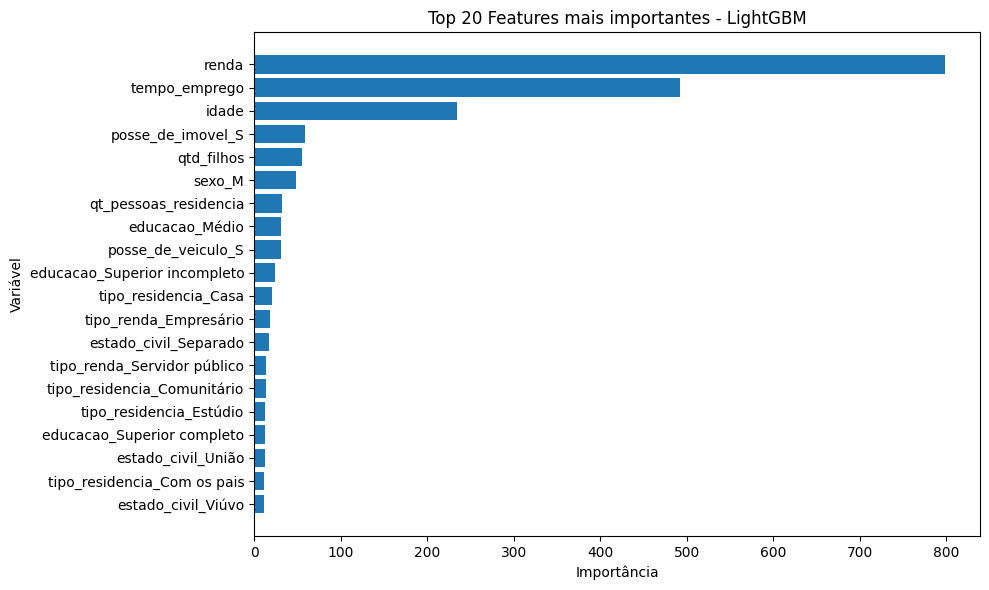

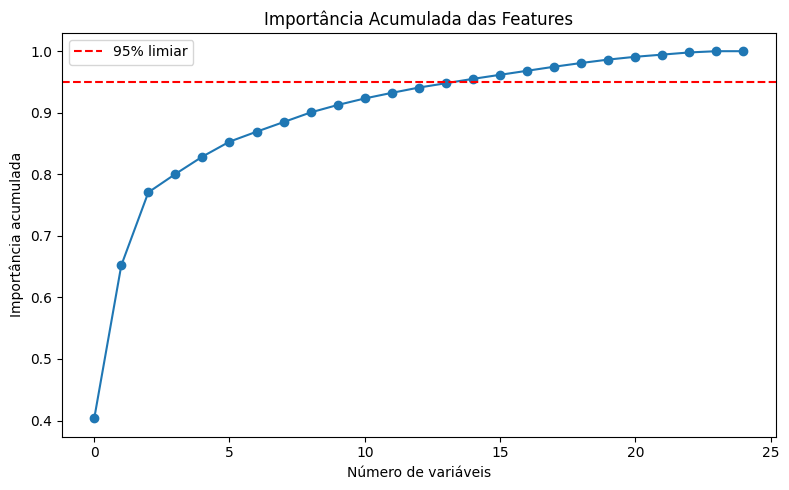

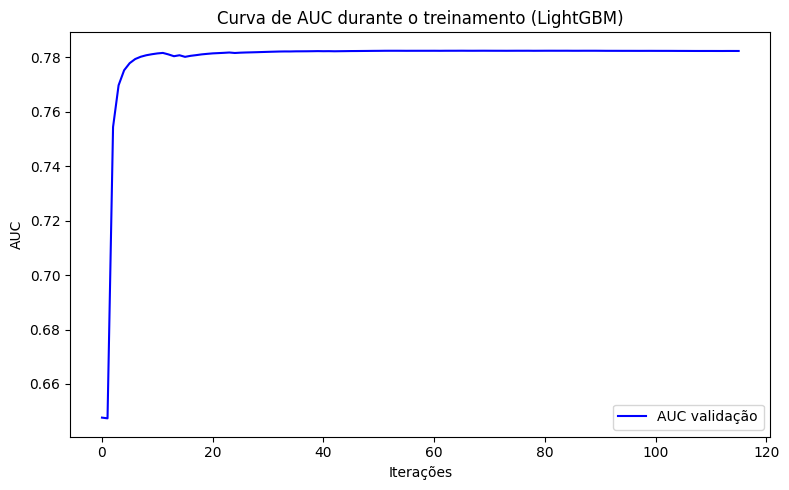

In [16]:
# Definir quantas features top serão exibidas
top_n = 20

# Extrair importância das features
importance = pd.DataFrame({
    'feature': X_train.columns,  # use X_train original ou pós-encoding se aplicável
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)
importance['cumulative_importance'] = importance['importance'].cumsum() / importance['importance'].sum()

# Gráfico Top N features
plt.figure(figsize=(10, 6))
top_features = importance.head(top_n)
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.title(f'Top {top_n} Features mais importantes - LightGBM')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

# Gráfico de importância acumulada
plt.figure(figsize=(8, 5))
plt.plot(
    range(len(importance)), 
    importance['cumulative_importance'], 
    marker='o'
)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% limiar')
plt.title('Importância Acumulada das Features')
plt.xlabel('Número de variáveis')
plt.ylabel('Importância acumulada')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico AUC durante treino (se model foi treinado com eval_set)
if hasattr(model, 'evals_result_'):
    results = model.evals_result_
    plt.figure(figsize=(8, 5))
    plt.plot(results['valid_0']['auc'], label='AUC validação', color='blue')
    plt.title('Curva de AUC durante o treinamento (LightGBM)')
    plt.xlabel('Iterações')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [18]:
X_top = X_encoded[selected_features].copy()
X_train_selected, X_valid_selected, y_train, y_valid = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Supondo df_features como DataFrame com todas as features que deseja reduzir
df_features = X_train_selected.copy()  # ou qualquer outro df de features

# 1️⃣ Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# 2️⃣ PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# 3️⃣ Criar DataFrame das componentes principais
df_pca = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(5)],
    index=df_features.index
)

# 4️⃣ Explicação de variância
explained_variance = pca.explained_variance_ratio_
print("Variância explicada por componente:", explained_variance)
print("Variância acumulada:", explained_variance.cumsum())


Variância explicada por componente: [0.17188917 0.11659768 0.09905106 0.08886962 0.08610478]
Variância acumulada: [0.17188917 0.28848684 0.3875379  0.47640753 0.56251231]


c:\Users\coimb\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


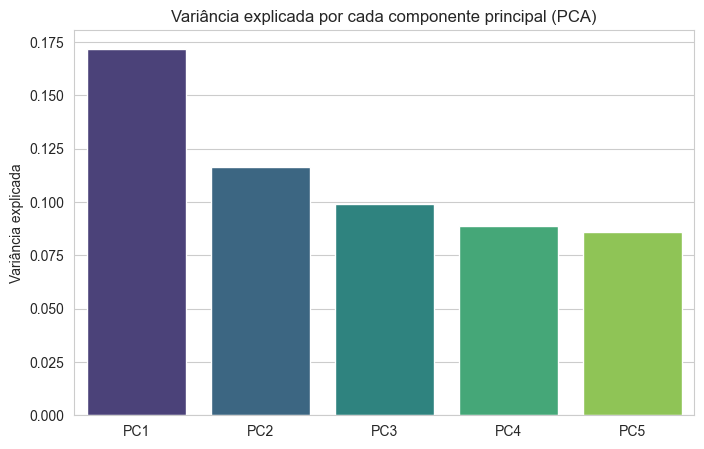

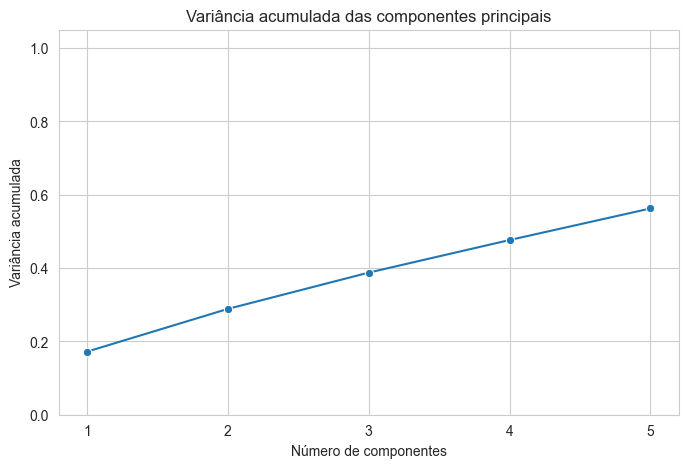

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 1️⃣ Variância explicada por componente
plt.figure(figsize=(8,5))
sns.barplot(x=[f'PC{i+1}' for i in range(5)], y=explained_variance, palette="viridis")
plt.ylabel("Variância explicada")
plt.title("Variância explicada por cada componente principal (PCA)")
plt.show()

# 2️⃣ Variância acumulada
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1,6), y=explained_variance.cumsum(), marker='o')
plt.xticks(range(1,6))
plt.ylim(0,1.05)
plt.xlabel("Número de componentes")
plt.ylabel("Variância acumulada")
plt.title("Variância acumulada das componentes principais")
plt.grid(True)
plt.show()


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

[LightGBM] [Info] Number of positive: 46914, number of negative: 553086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078190 -> initscore=-2.467197
[LightGBM] [Info] Start training from score -2.467197
[LightGBM] [Info] Number of positive: 46914, number of negative: 553086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info

c:\Users\coimb\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_core.py:1478: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


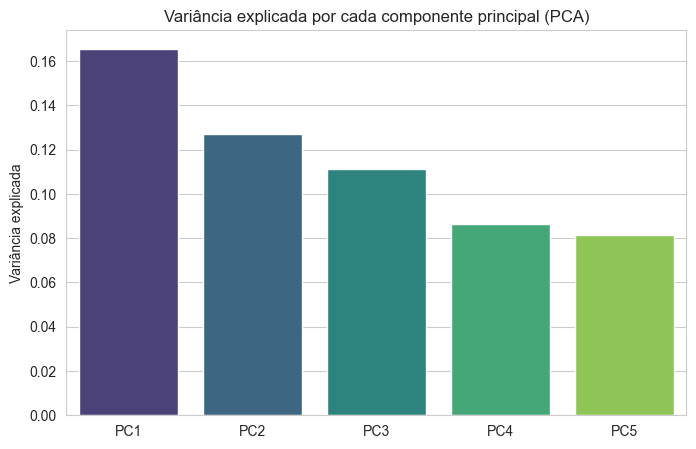

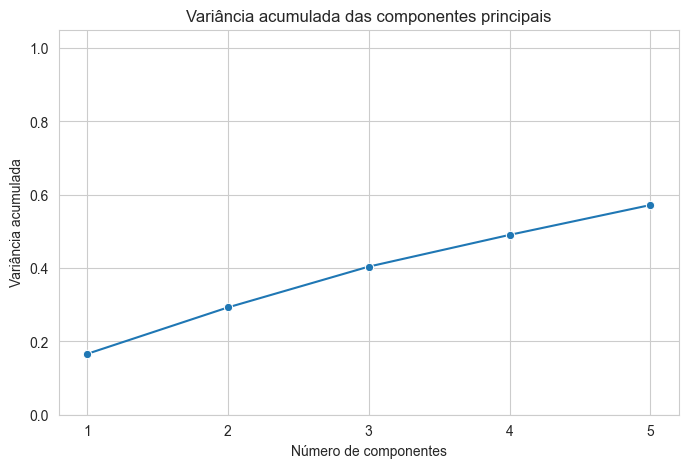

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Pré-processamento inicial
df = pd.read_feather('credit_scoring.ftr').copy()
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())
df['renda'] = np.log1p(df['renda'])
df['renda'] = np.clip(df['renda'], None, np.log1p(40594.15))
df['tempo_emprego'] = np.clip(df['tempo_emprego'], None, 25)
df['qt_pessoas_residencia'] = np.clip(df['qt_pessoas_residencia'], None, 6)
if 'index' in df.columns:
    df = df.drop(columns=['index'])

X = df.drop(columns=['mau', 'data_ref'])
y = df['mau'].astype(int)

# 2️⃣ Treino/validação
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Pré-processamento
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

# 4️⃣ Selector pós-encoding
class LGBMFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cumulative_importance_threshold=0.95, random_state=42):
        self.threshold = cumulative_importance_threshold
        self.random_state = random_state
        self.selected_features_ = None

    def fit(self, X, y):
        model = lgb.LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=self.random_state,
            n_jobs=-1
        )
        model.fit(X, y)
        importance = pd.DataFrame({
            'feature': np.arange(X.shape[1]),  # índice das colunas após encoding
            'importance': model.feature_importances_
        }).sort_values(by='importance', ascending=False)
        importance['cumulative_importance'] = importance['importance'].cumsum() / importance['importance'].sum()
        self.selected_features_ = importance[importance['cumulative_importance'] <= self.threshold]['feature'].tolist()
        return self

    def transform(self, X):
        return X[:, self.selected_features_]

# 5️⃣ Pipeline completo
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('feature_select', LGBMFeatureSelector(cumulative_importance_threshold=0.95)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# 6️⃣ Treinamento
pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_proba)
print(f"AUC validação: {auc:.4f}")

# 7️⃣ PCA - variância explicada
pca_stage = pipeline.named_steps['pca']
explained_variance = pca_stage.explained_variance_ratio_

sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x=[f'PC{i+1}' for i in range(5)], y=explained_variance, palette="viridis")
plt.ylabel("Variância explicada")
plt.title("Variância explicada por cada componente principal (PCA)")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(x=range(1,6), y=explained_variance.cumsum(), marker='o')
plt.xticks(range(1,6))
plt.ylim(0,1.05)
plt.xlabel("Número de componentes")
plt.ylabel("Variância acumulada")
plt.title("Variância acumulada das componentes principais")
plt.grid(True)
plt.show()


In [22]:
# Extrair as 5 PCs do pipeline para criar df_pca
X_train_pca = pipeline.named_steps['pca'].transform(
    pipeline.named_steps['scaler'].transform(
        pipeline.named_steps['feature_select'].transform(
            pipeline.named_steps['preprocess'].transform(X_train)
        )
    )
)

df_pca = pd.DataFrame(
    X_train_pca,
    columns=[f'PC{i+1}' for i in range(5)],
    index=X_train.index
)

# Adicionar target
df_pca['mau'] = y_train.values


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9219,0.7600,0.0075,0.5506,0.0147,0.0127,0.0573
1,0.9218,0.7564,0.0085,0.4956,0.0168,0.0142,0.0571
2,0.9218,0.7529,0.0082,0.5047,0.0162,0.0137,0.0567
3,0.9219,0.7522,0.0064,0.5600,0.0126,0.0109,0.0536
4,0.9219,0.7575,0.0069,0.5488,0.0135,0.0116,0.0548
Mean,0.9219,0.7558,0.0075,0.5319,0.0148,0.0126,0.0559
Std,0.0001,0.0029,0.0008,0.0264,0.0015,0.0012,0.0014


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7625,0.0123,0.5094,0.0241,0.0205,0.0700
1,0.9219,0.7599,0.0119,0.5200,0.0232,0.0198,0.0696
2,0.9217,0.7565,0.0132,0.4728,0.0258,0.0216,0.0689
3,0.9218,0.7549,0.0114,0.5102,0.0223,0.0190,0.0674
4,0.9217,0.7600,0.0102,0.4558,0.0200,0.0166,0.0589
Mean,0.9218,0.7588,0.0118,0.4936,0.0231,0.0195,0.0669
Std,0.0001,0.0027,0.0010,0.0248,0.0019,0.0017,0.0041


Fitting 5 folds for each of 50 candidates, totalling 250 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

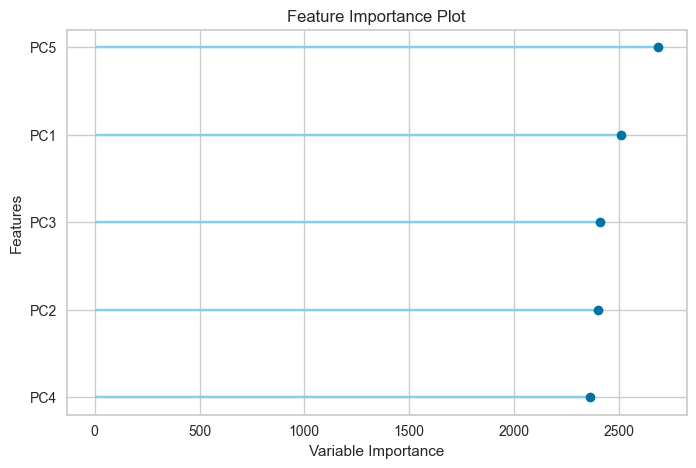

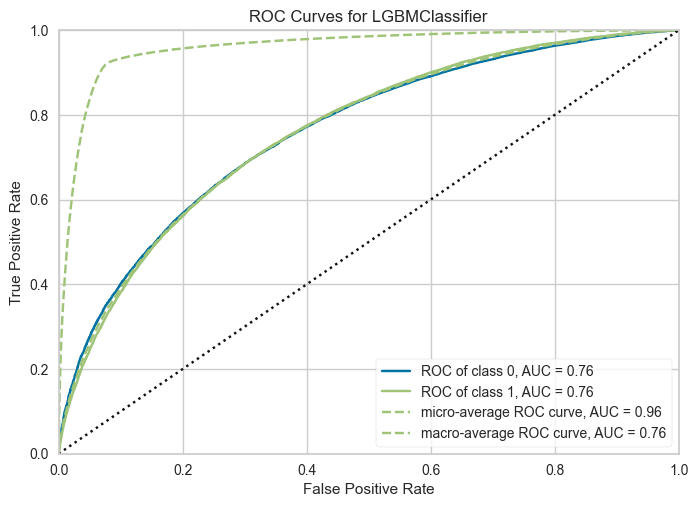

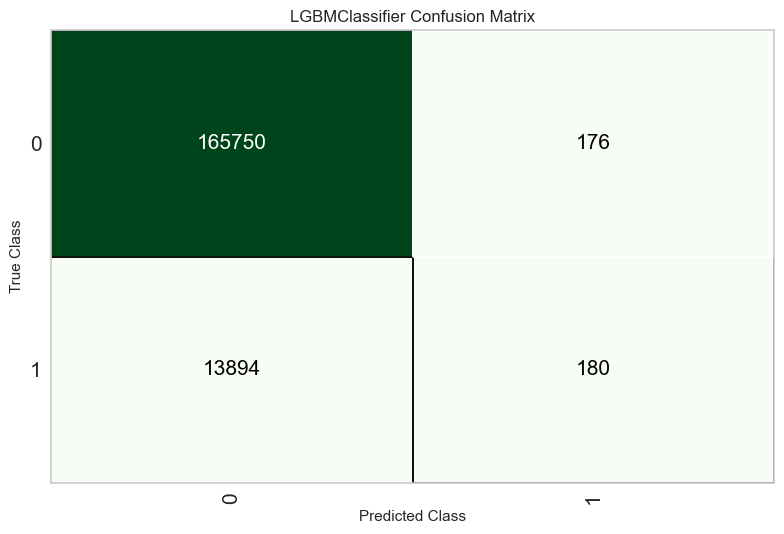

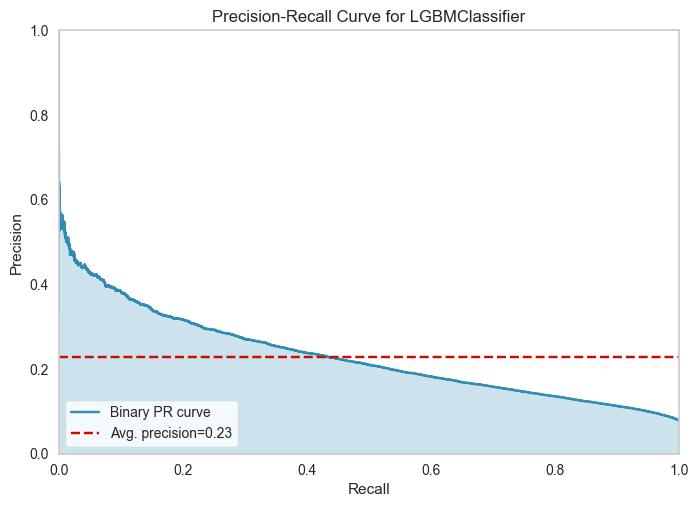

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transforme...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fr

In [23]:
import pandas as pd
import numpy as np
from pycaret.classification import *

# 1️⃣ Usar df_pca como base
# Supondo que df_pca já tenha sido criado:
# df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)], index=X_train.index)

# Copiando e adicionando target
df_pca_model = df_pca.copy()
df_pca_model['mau'] = y_train.values  # target do treino

# 2️⃣ Setup PyCaret para PCA (todas numéricas, sem categóricas)
exp = setup(
    data=df_pca_model,
    target='mau',
    numeric_features=[f'PC{i+1}' for i in range(5)],
    ignore_features=[],  # nenhuma
    normalize=False,      # PCA já normalizou/centralizou
    transformation=False, # PCA já transformou
    fold_shuffle=True,
    verbose=False
)

# 3️⃣ Criar e treinar modelo LightGBM
lgb_model = create_model('lightgbm', fold=5, round=4)

# 4️⃣ Ajustar hiperparâmetros (opcional)
lgb_tuned = tune_model(lgb_model, optimize='AUC', n_iter=50, fold=5, round=4)

# 5️⃣ Avaliar modelo com gráficos
evaluate_model(lgb_tuned)
plot_model(lgb_tuned, plot='feature')  # importância das PCs
plot_model(lgb_tuned, plot='auc')
plot_model(lgb_tuned, plot='confusion_matrix')
plot_model(lgb_tuned, plot='pr')

# 6️⃣ Finalizar pipeline
final_model = finalize_model(lgb_tuned)

# 7️⃣ Salvar pipeline final
save_model(final_model, 'credit_scoring_lightgbm_pca_pipeline')
